# Gemini Pro with LangChain on Google AI Studio

## Install packages

In [ ]:
%pip install --upgrade  langchain langchain-google-genai "langchain[docarray]"

In [ ]:
%pip install faiss-cpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 37.0 MB/s eta 0:00:00


In [ ]:
import os
import getpass
import requests
from PIL import Image
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.vectorstores import DocArrayInMemorySearch
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnableLambda, RunnablePassthrough

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import display, Markdown

In [ ]:
from langchain_community.vectorstores import FAISS

## Set API Key

In [ ]:
if "GOOGLE_API_KEY" not in os.environ:
    os.environ["GOOGLE_API_KEY"] = getpass.getpass("Provide your Google API Key")

Provide your Google API Key··········


## Custom Functions to load image

In [ ]:
def get_image(url, filename):
  content = requests.get(url).content
  with open(f'/content/{filename}.png', 'wb') as f:
    f.write(content)
  image = Image.open(f"/content/{filename}.png")
  image.show()
  return image

## Simple LLM chain

In [ ]:
llm = ChatGoogleGenerativeAI(model="gemini-pro")
result = llm.invoke("Write a ballad about Gemini Pro in around 3 sentences.")
print(result.content)

A celestial twin, Gemini Pro, bright,
In crypto's realm, it shines with all its might.
With speed and grace, it leads the digital fray,
A shining beacon in the blockchain's sway.


## Simple LLM chain with Chat

In [ ]:
model = ChatGoogleGenerativeAI(model="gemini-pro", convert_system_message_to_human=True)
print(
    model(
    [
        SystemMessage(content="Answer only yes or no."),
        HumanMessage(content="Is apple a fruit?"),
    ]
).content
)

Yes


## Multimodal llm chain

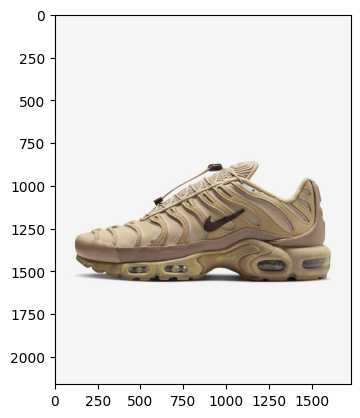

 This is a product image of a pair of Nike Air Max 95 sneakers in a tan, wheat colorway. The upper is made of mesh and suede, with a leather mudguard. The midsole is made of foam, with a visible air unit in the heel. The outsole is made of rubber, with a waffle pattern for traction.


In [ ]:
image = get_image("https://static.nike.com/a/images/t_PDP_1728_v1/f_auto,q_auto:eco/b434966d-c850-4aa7-be6c-e99c0e236362/air-max-plus-mens-shoes-3mH52P.png", "nike3")
plt.imshow(image)
plt.show()

llm = ChatGoogleGenerativeAI(model="gemini-pro-vision")
message = HumanMessage(
    content=[
        {
            "type": "text",
            "text": "What's in this image? provide full detail as possible.",
        },  # You can optionally provide text parts
        {"type": "image_url", "image_url": image},
    ]
)
print(
    llm.invoke([message]).content
)

## Mini RAG

In [ ]:
store_information = """

Nike Air Max Plus sneakers. They feature a brown upper with a black Nike Swoosh logo on the side and a visible Air Max unit in the heel. The sole is white.
Here are some more details about the Nike Air Max Plus:
Style: TN
Release date: January 1, 2017
Style code: 852630-300
Original retail price: $150 USD
The Air Max Plus, also known as the TN, is a popular Nike running shoe that was first released in 1998. It is known for its unique design, which includes a gradient upper, visible Air Max units, and a wavy outsole. The TN has been a popular shoe among sneakerheads and casual wearers alike for over two decades.
It features a brown upper with a black Swoosh logo and a white sole. The shoe is currently available for resale on the StockX marketplace for an average price of around $150 USD.
Nike Air Max Plus Store Location: "Kings Way, Kathmandu, Nepal".


Nike Dunk Low Retro sneakers.
Here are some more details about the Nike Dunk Low Retro:
Style: Low-top
Release date: October 31, 2020
Style code: DD1391-100
Original retail price: $100 USD
The Dunk Low Retro is a popular Nike skateboarding shoe that was first released in 1985. It is a classic silhouette that has been released in a wide variety of colors and materials over the years.
The shoes in the image are currently available for resale on the StockX marketplace for an average price of around $200 USD.
Nike Dunk Low Retro sneakers Store Location: "Patan, Lalitpur, Nepal".


Nike slide/sandal.
They appear to be the Nike Slide/Sandal, which is a unisex slide/sandal.
Here are some of the features:
Soft, one-piece upper: The upper is made of a soft, synthetic material that provides comfort and support.
Phylon midsole: The midsole is made of Phylon, which provides cushioning and support.
Rubber outsole: The outsole is made of rubber for traction and durability.
Swoosh logo: The Nike Swoosh logo is on the strap of the sandal.
Available in a variety of colors: The Nike Benassi Solarsoft Sandal is available in a variety of colors, including black, white, and beige.
Nike off courte slides store location: "Bhaktapur, Nepal".

"""

embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")

vectorstore = FAISS.from_texts(
    [store_information], embedding=embeddings
)
retriever = vectorstore.as_retriever()

In [ ]:
llm_text = ChatGoogleGenerativeAI(model="gemini-pro")
template = """
```
{context}
```

{information}


Provide brief information and store location.
"""
prompt = ChatPromptTemplate.from_template(template)

rag_chain = (
    {"context": retriever, "information": RunnablePassthrough()}
    | prompt
    | llm_text
    | StrOutputParser()
)

In [ ]:
llm_vision = ChatGoogleGenerativeAI(model="gemini-pro-vision", temperature=0.0)
full_chain = (
    RunnablePassthrough() | llm_vision | StrOutputParser() | rag_chain
)

In [ ]:
url_1 = "https://static.nike.com/a/images/t_PDP_1728_v1/f_auto,q_auto:eco/b434966d-c850-4aa7-be6c-e99c0e236362/air-max-plus-mens-shoes-3mH52P.png"

url_2 = "https://static.nike.com/a/images/t_PDP_1728_v1/f_auto,q_auto:eco/0f557b1f-ba79-419c-a814-f7b5d117fbb2/dunk-low-retro-shoes-bCzchX.png"

url_3 = "https://static.nike.com/a/images/t_PDP_1728_v1/f_auto,q_auto:eco/252f2db6-d426-4931-80a0-8b7f8f875536/calm-slides-K7mr3W.png"

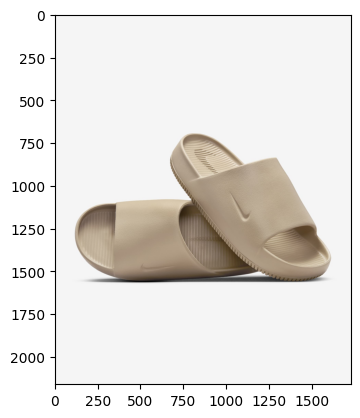

**Nike Offcourt Slide**
- Soft, one-piece upper
- Plush foam midsole
- Durable rubber outsole
- Available in a variety of colors

**Store Location:** Bhaktapur, Nepal

In [ ]:
image = get_image(url_3, "nike3")
plt.imshow(image)
plt.show()

message = HumanMessage(
    content=[
        {
            "type": "text",
            "text": "Provide information on Brand and model of given sneaker.",
        },  # You can optionally provide text parts
        {"type": "image_url", "image_url": image},
    ]
)


result = full_chain.invoke([message])
display(Markdown(result))